In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [2]:
%load_ext autoreload
%autoreload 2
import math, random, copy, numpy as np
import cProfile
import yaml
from utils import get_class_from_class_path, HELMConverter
from node import MolSentenceNode #TODO: change after Filter implementation <- ?
from generator import MCTS

c:\Users\fsfsf\anaconda3\envs\molgen-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
config_path = "config/mcts_smiles.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class_path, model_dir, lang_class_path, lang_path = (conf.get(k) for k in ("model_class_path", "model_dir", "lang_class_path", "lang_path"))
lang_class = get_class_from_class_path(lang_class_path)
lang = lang_class.load(repo_root + lang_path)
if lang_class_path.endswith("HELM"): #TODO: should be removed after .lang inclusion
    lang.converter = HELMConverter().load(repo_root + "data/helm/library/chembl_35_monomer_library.xml")
model_class = get_class_from_class_path(model_class_path)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class_path, reward_conf = (conf.get(k) for k in ("reward_class_path", "reward_conf"))
reward_class = get_class_from_class_path(reward_class_path)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class_path", "policy_conf"))
policy_class = get_class_from_class_path(policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = get_class_from_class_path(s.pop("filter_class_path"))
    filters.append(filter_class(**s))

In [7]:
for f in filters:
    print(vars(f))

{}
{'max_weight': 500, 'max_logP': 5, 'max_hydrogen_bond_donors': 5, 'max_hydrogen_bond_acceptors': 10, 'max_rotatable_bonds': inf}
{'max_logP': inf, 'min_logP': 0}
{'max_ring_size': 6, 'min_ring_size': None}


Search is started.
0- time: 0.19, count_rollouts: 1, reward: 0.3153813794205771, node: COC(=O)c1ccc(CNC(=O)NCc2ccc(Cl)c(F)c2)cc1
1- time: 0.43, count_rollouts: 2, reward: 0.2727940141883562, node: O=C(N[C@@H]1CCCN(c2ccn[nH]2)C1)c1ccc(N2CCCCC2)cc1
2- time: 0.60, count_rollouts: 3, reward: 0.2507921962823376, node: N#CCOc1ccccc1C(=O)Nc1cc(N)ccc1F
3- time: 0.86, count_rollouts: 5, reward: 0.20853571607474974, node: Fc1ccc(-n2ccs2)cc1NC(=O)[C@@H]1CC[NH+](Cc2cnccc2)C1
4- time: 1.04, count_rollouts: 6, reward: 0.08734684083583862, node: [NH3+][C@@H](c1cccc(Cl)c1)NC(=O)[C@H]1CCCO1
5- time: 1.17, count_rollouts: 7, reward: 0.32751310468315503, node: Clc1ccc(CN2CN(Cc3nn[nH]c3-c3ccccc3)CC2)cc1
6- time: 1.32, count_rollouts: 8, reward: 0.3931664834118445, node: S=C(NCCCSc1ccccc1)Nc1ccccc1
7- time: 1.62, count_rollouts: 10, reward: 0.04198430555232194, node: [C@H][C@H](C[NH3+])Nc1ccccc1
8- time: 1.84, count_rollouts: 12, reward: 0.1300984561544309, node: [O-]c1ncc2ccccc2c1
9- time: 1.91, count_rol

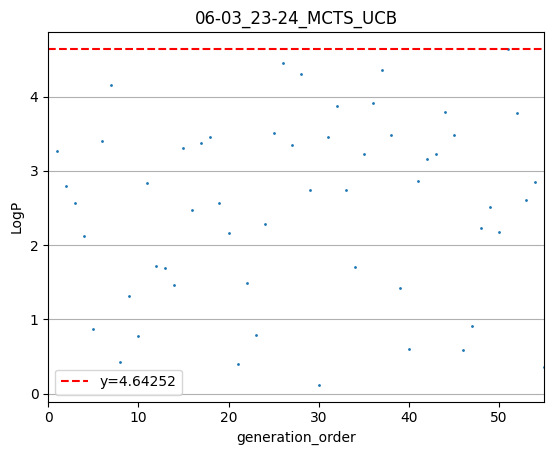

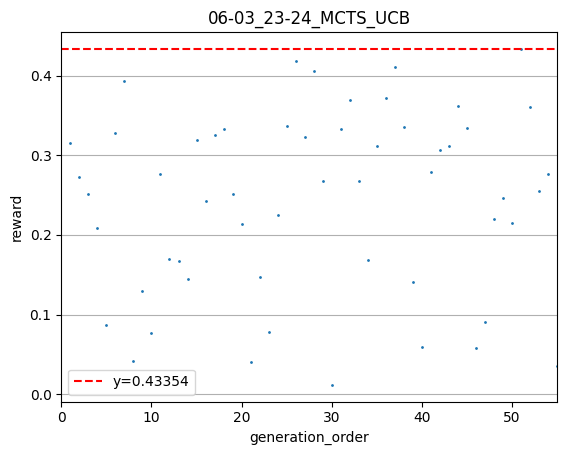

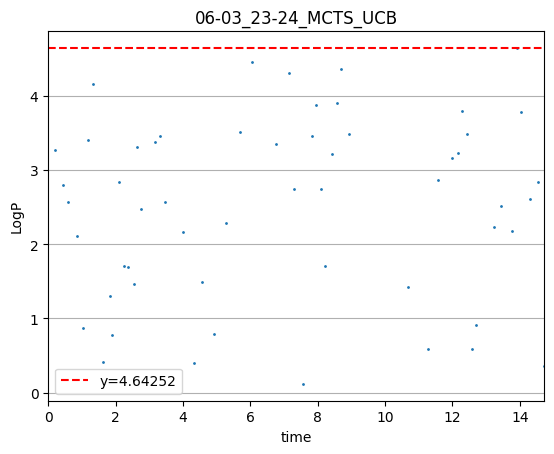

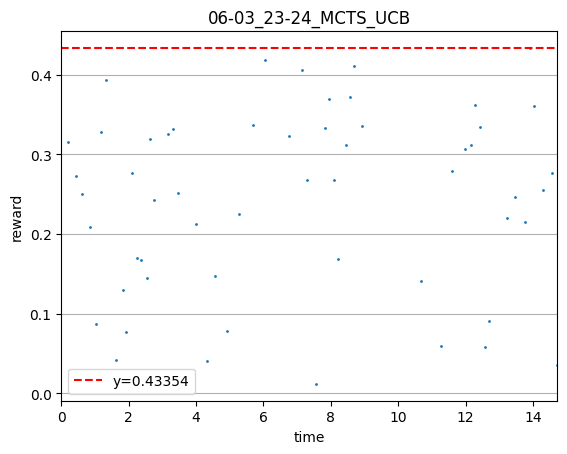

Search is completed.


In [4]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang)

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, filters=filters, output_dir=output_dir)
generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)